## Import Libraries

In [59]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [60]:
'''
training_inputs = np.array([[3, 1.5],
                           [2, 1],
                           [4, 1.5],
                           [3, 1],
                           [3.5, 5],
                           [2, 0.5],
                           [5.5, 1],
                           [1, 1],
                           [4.5, 1]])
training_outputs = np.array([[1, 0, 1, 0, 1, 0, 1, 0, 1]]).T 
'''

dataset = pd.read_csv('UTM_EnvironmentalDataSet_2018_4.csv')
X = dataset.iloc[:,12:14]
Y = dataset.iloc[:,15]

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2)
training_inputs = X_train.values.tolist()
testing_inputs = X_test.values.tolist()
training_outputs = Y_train.values.tolist()
testing_outputs = Y_test.values.tolist()
final_weight = []


training_inputs = np.array(training_inputs)
training_outputs = np.array([training_outputs]).T
testing_inputs = np.array(testing_inputs)
testing_outputs = np.array([testing_outputs]).T

print(training_outputs.shape)

(45, 1)


## Objective Functions

In [61]:
def objective1(x):
    y_pred = ANN(x)
    return RMSE(y_pred)
    #loss= metrics.hinge_loss(training_outputs, y_pred)
    #return loss

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def RMSE(z):
    loss = np.sum((z - training_outputs) ** 2)
    #print(loss)
    return np.sqrt(loss / 9)

def ANN(w):
    z1 = sigmoid(np.dot(training_inputs, w[0:2]))
    z2 = sigmoid(np.dot(training_inputs, w[2:4]))
    z3 = sigmoid(np.dot(training_inputs, w[4:6]))
    z4 = sigmoid(np.dot(np.array([z1, z2, z3]).T, w[6:9]))
    
    #print(z4)
    output=np.resize(z4,(45,1))
    #print(output)
    return output


def objective2(x):
    y_pred = ANN(x)
    #loss= metrics.log_loss(training_outputs, y_pred)
    #return loss
    return RMSE(y_pred)

## Helper Methods

In [62]:
def index_locator(a,list):
    for i in range(0,len(list)):
        if list[i] == a:
            return i
    return -1


def sort_by_values(list1, values):
    sorted_list = []
    while(len(sorted_list)!=len(list1)):
        if index_locator(min(values),values) in list1:
            sorted_list.append(index_locator(min(values),values))
        values[index_locator(min(values),values)] = math.inf
    return sorted_list


def crowding_distance(values1, values2, front):
    distance = [0 for i in range(0,len(front))]
    sorted1 = sort_by_values(front, values1[:])
    sorted2 = sort_by_values(front, values2[:])
    distance[0] = 9999999999999999
    distance[len(front) - 1] = 9999999999999999
    for k in range(1,len(front)-1):
        distance[k] = distance[k]+ (values1[sorted1[k+1]] - values2[sorted1[k-1]])/(max(values1)-min(values1))
    for k in range(1,len(front)-1):
        distance[k] = distance[k]+ (values1[sorted2[k+1]] - values2[sorted2[k-1]])/(max(values2)-min(values2))
    return distance

## Genetic Operator

In [63]:
def crossover(a,b):
    r=random.random()
    if r>0.5:
        return mutation(np.add(a,b)/2)
    else:
        return mutation(np.subtract(a,b)/2)

def mutation(solution):
    mutation_prob = random.random()
    if mutation_prob <0.5:
        solution = np.random.rand(9,1)
    return solution

## Algorithm

In [64]:
def non_dominated_sorting_algorithm(values1, values2):
    S = [ [] for i in range(0, len(values1)) ]
    front = [[]]
    n = [ 0 for i in range(0, len(values1)) ]
    rank = [0 for i in range(0, len(values1)) ]

    for p in range(0, len(values1)):
        S[p] = []
        n[p] = 0
        for q in range(0, len(values1)):
            if (values1[p] < values1[q] and values2[p] < values2[q]) or (values1[p] <= values1[q] and values2[p] < values2[q]) or (values1[p] < values1[q] and values2[p] <= values2[q]):
                if q not in S[p]:
                    S[p].append(q)
            elif (values1[q] < values1[p] and values2[q] < values2[p]) or (values1[q] <= values1[p] and values2[q] < values2[p]) or (values1[q] < values1[p] and values2[q] <= values2[p]):
                n[p] = n[p] + 1
        if n[p] == 0:
            rank[p] = 0
            if p not in front[0]:
                front[0].append(p)
    i = 0
    while(front[i] != []):
        Q=[]
        for p in front[i]:
            for q in S[p]:
                n[q] =n[q] - 1
                if( n[q]==0):
                    rank[q]=i+1
                    if q not in Q:
                        Q.append(q)
        i = i+1
        front.append(Q)
    del front[len(front)-1]
    return front

## Final Implementation

In [68]:
def nsga2(population,max_gen):
    
    solution = []
    gen_no = 0
    for i in range(0, population):
        solution.append(np.random.rand(9,1))
    #solution = np.asarray(s)
    
    while(gen_no < max_gen):
        objective1_values = [ objective1(solution[i]) for i in range(0, population)]
        objective2_values = [ objective2(solution[i]) for i in range(0, population)]
        
        non_dominated_sorted_solution = non_dominated_sorting_algorithm(objective1_values[:],objective2_values[:])
        
        print('Best Front for Generation:',gen_no)
        for values in non_dominated_sorted_solution[0]:
            print(np.round(solution[values], 3), end = " ")
        print("\n")
        
        crowding_distance_values = []
        for i in range(0, len(non_dominated_sorted_solution)):
            crowding_distance_values.append(crowding_distance(objective1_values[:],objective2_values[:],non_dominated_sorted_solution[i][:]))
        solution2 = solution[:]
            
        #Generating Offspring
        while(len(solution2) != 2 * population):
            a1 = random.randint(0, population-1)
            b1 = random.randint(0, population-1)
            solution2.append(crossover(solution[a1], solution[b1]))
            
        objective1_values2 = [ objective1(solution2[i]) for i in range(0,2 * population)]
        objective2_values2 = [ objective2(solution2[i]) for i in range(0,2 * population)]
        
        non_dominated_sorted_solution2 = non_dominated_sorting_algorithm(objective1_values2[:],objective2_values2[:])
        crowding_distance_values2 = []
        for i in range(0,len(non_dominated_sorted_solution2)):
            crowding_distance_values2.append(crowding_distance(objective1_values2[:],objective2_values2[:],non_dominated_sorted_solution2[i][:]))
        new_solution = []
        
        for i in range(0,len(non_dominated_sorted_solution2)):
            non_dominated_sorted_solution2_1 = [index_locator(non_dominated_sorted_solution2[i][j],non_dominated_sorted_solution2[i] ) for j in range(0,len(non_dominated_sorted_solution2[i]))]
            front22 = sort_by_values(non_dominated_sorted_solution2_1[:], crowding_distance_values2[i][:])
            front = [non_dominated_sorted_solution2[i][front22[j]] for j in range(0,len(non_dominated_sorted_solution2[i]))]
            front.reverse()
            for value in front:
                new_solution.append(value)
                if(len(new_solution) == population):
                    break
            if (len(new_solution) == population):
                break
        solution = [solution2[i] for i in new_solution]
        gen_no = gen_no + 1
    return [objective1_values, objective2_values, solution]

## Plot

In [69]:
def non_dominating_curve_plot(objective1_values, objective2_values):
    plt.figure(figsize=(15,8))
    plt.xlabel('Hinge Loss')
    plt.ylabel('Binary Cross-entropy')
    plt.scatter(objective1_values, objective2_values)

## Driver Code

Best Front for Generation: 0
[[0.155]
 [0.047]
 [0.019]
 [0.009]
 [0.982]
 [0.01 ]
 [0.279]
 [0.377]
 [0.015]] 

Best Front for Generation: 1
[[ 0.018]
 [-0.009]
 [-0.091]
 [-0.312]
 [-0.028]
 [-0.213]
 [-0.346]
 [-0.203]
 [ 0.16 ]] 

Best Front for Generation: 2
[[ 0.018]
 [-0.009]
 [-0.091]
 [-0.312]
 [-0.028]
 [-0.213]
 [-0.346]
 [-0.203]
 [ 0.16 ]] 

Best Front for Generation: 3
[[ 0.018]
 [-0.009]
 [-0.091]
 [-0.312]
 [-0.028]
 [-0.213]
 [-0.346]
 [-0.203]
 [ 0.16 ]] 

Best Front for Generation: 4
[[ 0.018]
 [-0.009]
 [-0.091]
 [-0.312]
 [-0.028]
 [-0.213]
 [-0.346]
 [-0.203]
 [ 0.16 ]] 

Best Front for Generation: 5
[[ 0.018]
 [-0.009]
 [-0.091]
 [-0.312]
 [-0.028]
 [-0.213]
 [-0.346]
 [-0.203]
 [ 0.16 ]] 

Best Front for Generation: 6
[[ 0.018]
 [-0.009]
 [-0.091]
 [-0.312]
 [-0.028]
 [-0.213]
 [-0.346]
 [-0.203]
 [ 0.16 ]] 

Best Front for Generation: 7
[[ 0.018]
 [-0.009]
 [-0.091]
 [-0.312]
 [-0.028]
 [-0.213]
 [-0.346]
 [-0.203]
 [ 0.16 ]] 

Best Front for Generation: 8
[[ 0

Best Front for Generation: 67
[[ 0.09 ]
 [ 0.009]
 [ 0.092]
 [-0.072]
 [-0.075]
 [-0.058]
 [-0.227]
 [-0.094]
 [ 0.037]] 

Best Front for Generation: 68
[[ 0.09 ]
 [ 0.009]
 [ 0.092]
 [-0.072]
 [-0.075]
 [-0.058]
 [-0.227]
 [-0.094]
 [ 0.037]] 

Best Front for Generation: 69
[[ 0.09 ]
 [ 0.009]
 [ 0.092]
 [-0.072]
 [-0.075]
 [-0.058]
 [-0.227]
 [-0.094]
 [ 0.037]] 

Best Front for Generation: 70
[[ 0.09 ]
 [ 0.009]
 [ 0.092]
 [-0.072]
 [-0.075]
 [-0.058]
 [-0.227]
 [-0.094]
 [ 0.037]] 

Best Front for Generation: 71
[[ 0.09 ]
 [ 0.009]
 [ 0.092]
 [-0.072]
 [-0.075]
 [-0.058]
 [-0.227]
 [-0.094]
 [ 0.037]] 

Best Front for Generation: 72
[[ 0.09 ]
 [ 0.009]
 [ 0.092]
 [-0.072]
 [-0.075]
 [-0.058]
 [-0.227]
 [-0.094]
 [ 0.037]] 

Best Front for Generation: 73
[[ 0.09 ]
 [ 0.009]
 [ 0.092]
 [-0.072]
 [-0.075]
 [-0.058]
 [-0.227]
 [-0.094]
 [ 0.037]] 

Best Front for Generation: 74
[[ 0.09 ]
 [ 0.009]
 [ 0.092]
 [-0.072]
 [-0.075]
 [-0.058]
 [-0.227]
 [-0.094]
 [ 0.037]] 

Best Front for G

Best Front for Generation: 114
[[ 0.09 ]
 [ 0.009]
 [ 0.092]
 [-0.072]
 [-0.075]
 [-0.058]
 [-0.227]
 [-0.094]
 [ 0.037]] [[ 0.09 ]
 [ 0.009]
 [ 0.092]
 [-0.072]
 [-0.075]
 [-0.058]
 [-0.227]
 [-0.094]
 [ 0.037]] 

Best Front for Generation: 115
[[ 0.09 ]
 [ 0.009]
 [ 0.092]
 [-0.072]
 [-0.075]
 [-0.058]
 [-0.227]
 [-0.094]
 [ 0.037]] [[ 0.09 ]
 [ 0.009]
 [ 0.092]
 [-0.072]
 [-0.075]
 [-0.058]
 [-0.227]
 [-0.094]
 [ 0.037]] 

Best Front for Generation: 116
[[ 0.09 ]
 [ 0.009]
 [ 0.092]
 [-0.072]
 [-0.075]
 [-0.058]
 [-0.227]
 [-0.094]
 [ 0.037]] [[ 0.09 ]
 [ 0.009]
 [ 0.092]
 [-0.072]
 [-0.075]
 [-0.058]
 [-0.227]
 [-0.094]
 [ 0.037]] 

Best Front for Generation: 117
[[ 0.09 ]
 [ 0.009]
 [ 0.092]
 [-0.072]
 [-0.075]
 [-0.058]
 [-0.227]
 [-0.094]
 [ 0.037]] [[ 0.09 ]
 [ 0.009]
 [ 0.092]
 [-0.072]
 [-0.075]
 [-0.058]
 [-0.227]
 [-0.094]
 [ 0.037]] 

Best Front for Generation: 118
[[ 0.09 ]
 [ 0.009]
 [ 0.092]
 [-0.072]
 [-0.075]
 [-0.058]
 [-0.227]
 [-0.094]
 [ 0.037]] [[ 0.09 ]
 [ 0.009

Best Front for Generation: 140
[[ 0.09 ]
 [ 0.009]
 [ 0.092]
 [-0.072]
 [-0.075]
 [-0.058]
 [-0.227]
 [-0.094]
 [ 0.037]] [[ 0.09 ]
 [ 0.009]
 [ 0.092]
 [-0.072]
 [-0.075]
 [-0.058]
 [-0.227]
 [-0.094]
 [ 0.037]] [[ 0.09 ]
 [ 0.009]
 [ 0.092]
 [-0.072]
 [-0.075]
 [-0.058]
 [-0.227]
 [-0.094]
 [ 0.037]] [[ 0.09 ]
 [ 0.009]
 [ 0.092]
 [-0.072]
 [-0.075]
 [-0.058]
 [-0.227]
 [-0.094]
 [ 0.037]] [[ 0.09 ]
 [ 0.009]
 [ 0.092]
 [-0.072]
 [-0.075]
 [-0.058]
 [-0.227]
 [-0.094]
 [ 0.037]] 

Best Front for Generation: 141
[[ 0.09 ]
 [ 0.009]
 [ 0.092]
 [-0.072]
 [-0.075]
 [-0.058]
 [-0.227]
 [-0.094]
 [ 0.037]] [[ 0.09 ]
 [ 0.009]
 [ 0.092]
 [-0.072]
 [-0.075]
 [-0.058]
 [-0.227]
 [-0.094]
 [ 0.037]] [[ 0.09 ]
 [ 0.009]
 [ 0.092]
 [-0.072]
 [-0.075]
 [-0.058]
 [-0.227]
 [-0.094]
 [ 0.037]] [[ 0.09 ]
 [ 0.009]
 [ 0.092]
 [-0.072]
 [-0.075]
 [-0.058]
 [-0.227]
 [-0.094]
 [ 0.037]] [[ 0.09 ]
 [ 0.009]
 [ 0.092]
 [-0.072]
 [-0.075]
 [-0.058]
 [-0.227]
 [-0.094]
 [ 0.037]] 

Best Front for Generatio

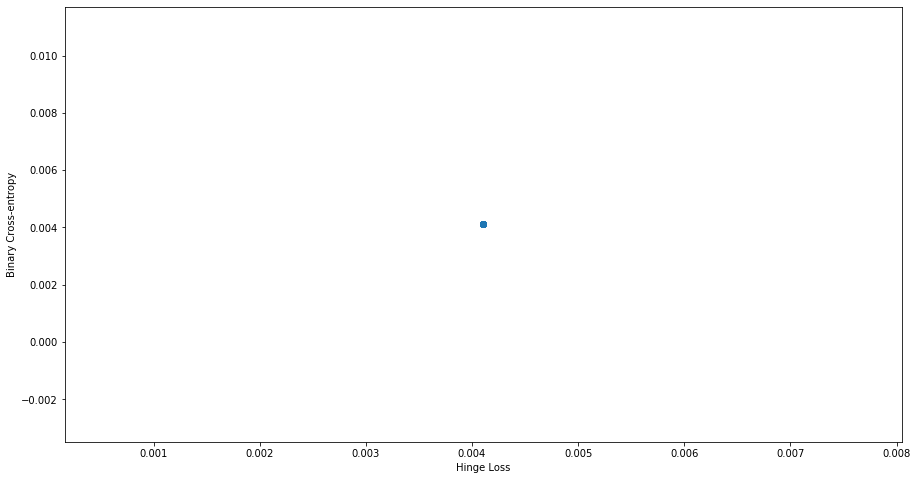

In [70]:
population = 50
max_gen = 150
#min_value= -1
#max_value= 1

if __name__ == "__main__":
    objective1_values, objective2_values, front = nsga2(population, max_gen)
    non_dominating_curve_plot(objective1_values, objective2_values)
    

In [73]:
weight = front[0]

z1 = sigmoid(np.dot(testing_inputs, weight[0:2]))
z2 = sigmoid(np.dot(testing_inputs, weight[2:4]))
z3 = sigmoid(np.dot(testing_inputs, weight[4:6]))
#print(np.array([z1, z2, z3]))
z4 = sigmoid(np.dot(np.array([z1, z2, z3]).T, weight[6:9]))

y_pred=np.resize(z4,(12,1))

explained_variance=metrics.explained_variance_score(testing_outputs, y_pred)
print(explained_variance)

-11.762890521970293


In [74]:
max_error=metrics.max_error(testing_outputs, y_pred)
print(max_error)

0.003378628624382818


In [75]:
r2_score=metrics.r2_score(testing_outputs, y_pred)
print(r2_score)

-12.956104224854522


In [76]:
mean_squared_log_error=metrics.mean_squared_log_error(testing_outputs, y_pred)
print(mean_squared_log_error)

2.1603028001005774e-06


In [77]:
mean_absolute_error=metrics.mean_absolute_error(testing_outputs, y_pred)
print(mean_absolute_error)

0.0019020753898988153
